In [1]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# # ---- BWR ---- #
# import bwr
# import emd
# import pywt
# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


# ---- PyTorch ---- #
import torch
import torchvision
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import torchvision.ops as ops
import tensorboard
from tensorboardX import SummaryWriter

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Summary ---- #
import pytorch_model_summary



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
        embeddings = self.patch_embeddings(x)

        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)
        x += self.positions
        return x

In [4]:
embed = ViTEmbeddings(12,768,20,dropout=0.0)
embed(torch.randn(16,12,5000)).shape

torch.Size([16, 251, 768])

In [5]:
class MLP(nn.Module):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.2, mlp_dim=256):
        super().__init__()
        self.mlps = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = self.mlps(x)
        return x

In [6]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.2, dropout=0.2, sd_survive=0.0,**kwargs):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout, bias=True, batch_first=True)
        self.lnorm = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)
        self.mlp = MLP(emb_size, expansion=f_expansion, dropout=f_dropout, mlp_dim=256)
        self.sd_survive=sd_survive
        self.actv1 = nn.GELU()
        self.actv2 = nn.GELU()
    
        self.stochasticLayer = ops.StochasticDepth(sd_survive, "row")
        
    def forward(self, x):
        x_norm = self.lnorm(x)
        x_norm, weight = self.attn(x_norm, x_norm, x_norm, average_attn_weights=False)
        x_norm = self.stochasticLayer(x_norm)
        x = torch.add(x_norm, x)
        x2_norm = self.lnorm(x)
        x2_norm = self.mlp(x2_norm)
        x2_norm = self.stochasticLayer(x2_norm)
        x2 = torch.add(x2_norm, x)
        print(self.sd_survive)
        return x2
    
    def get_attention_scores(self, inputs):
        x = self.lnorm(inputs)
        output, weight = self.attn(x, x, x, average_attn_weights=False)
        print(output.shape, weight.shape)
        return weight

In [7]:
encoder = EncoderBlock(mlp_dim=256)
x = encoder(torch.randn(16,251,768))
encoder.get_attention_scores(torch.randn(16,251,768)).shape
#N L S (L : Target_seqeunce Length, S : Source Sequence Length, N : Batch)
# 사실상 N이 Batch이기 때문에, 16, 6, 251, 251 이런식으로 나와야함
# 씨ㅣㅣㅣ빕ㅂㄹㄹ드디어 나왔다ㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏ

torch.Size([16, 251, 768]) torch.Size([16, 6, 251, 251])


torch.Size([16, 6, 251, 251])

In [8]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            nn.Dropout(0.2),
            nn.Linear(emb_size, n_classes)
        )

In [9]:
class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int= 6, mlp_dim: int=256):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        self.mlp_dim = 256
        self.sd_survive = np.linspace(0, 0.4, depth)
        self.Blocks = nn.ModuleList([
            EncoderBlock(mlp_dim=256, sd_survive=sd_survive[i]) for i in range(depth)
        ])
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
    
    def forward(self, x):
        x = self.Embeddings(x)
        for block in self.Blocks:
            x = block(x)
        result = self.ClassificationHead(x)
        return result
    
    def get_last_selfattention(self, inputs):
        x = self.Embeddings(inputs)
        for block in self.Blocks[:-1]:
            x = block(x)
        return self.Blocks[-1].get_attention_scores(x)

# DataLoader and shapes

In [10]:
x_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_train.npy")
y_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_train.npy")
x_valid = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_valid.npy")
y_valid = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_valid.npy")
x_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_test.npy")
y_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_test.npy")

In [11]:
x_train.shape, x_test.shape, x_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((13976, 12, 5000),
 (4368, 12, 5000),
 (3493, 12, 5000),
 (3493, 5),
 (13976, 5),
 (4368, 5))

['NORM', 'MI', 'STTC', 'HYP', 'CD']
[1. 0. 0. 0. 0.]


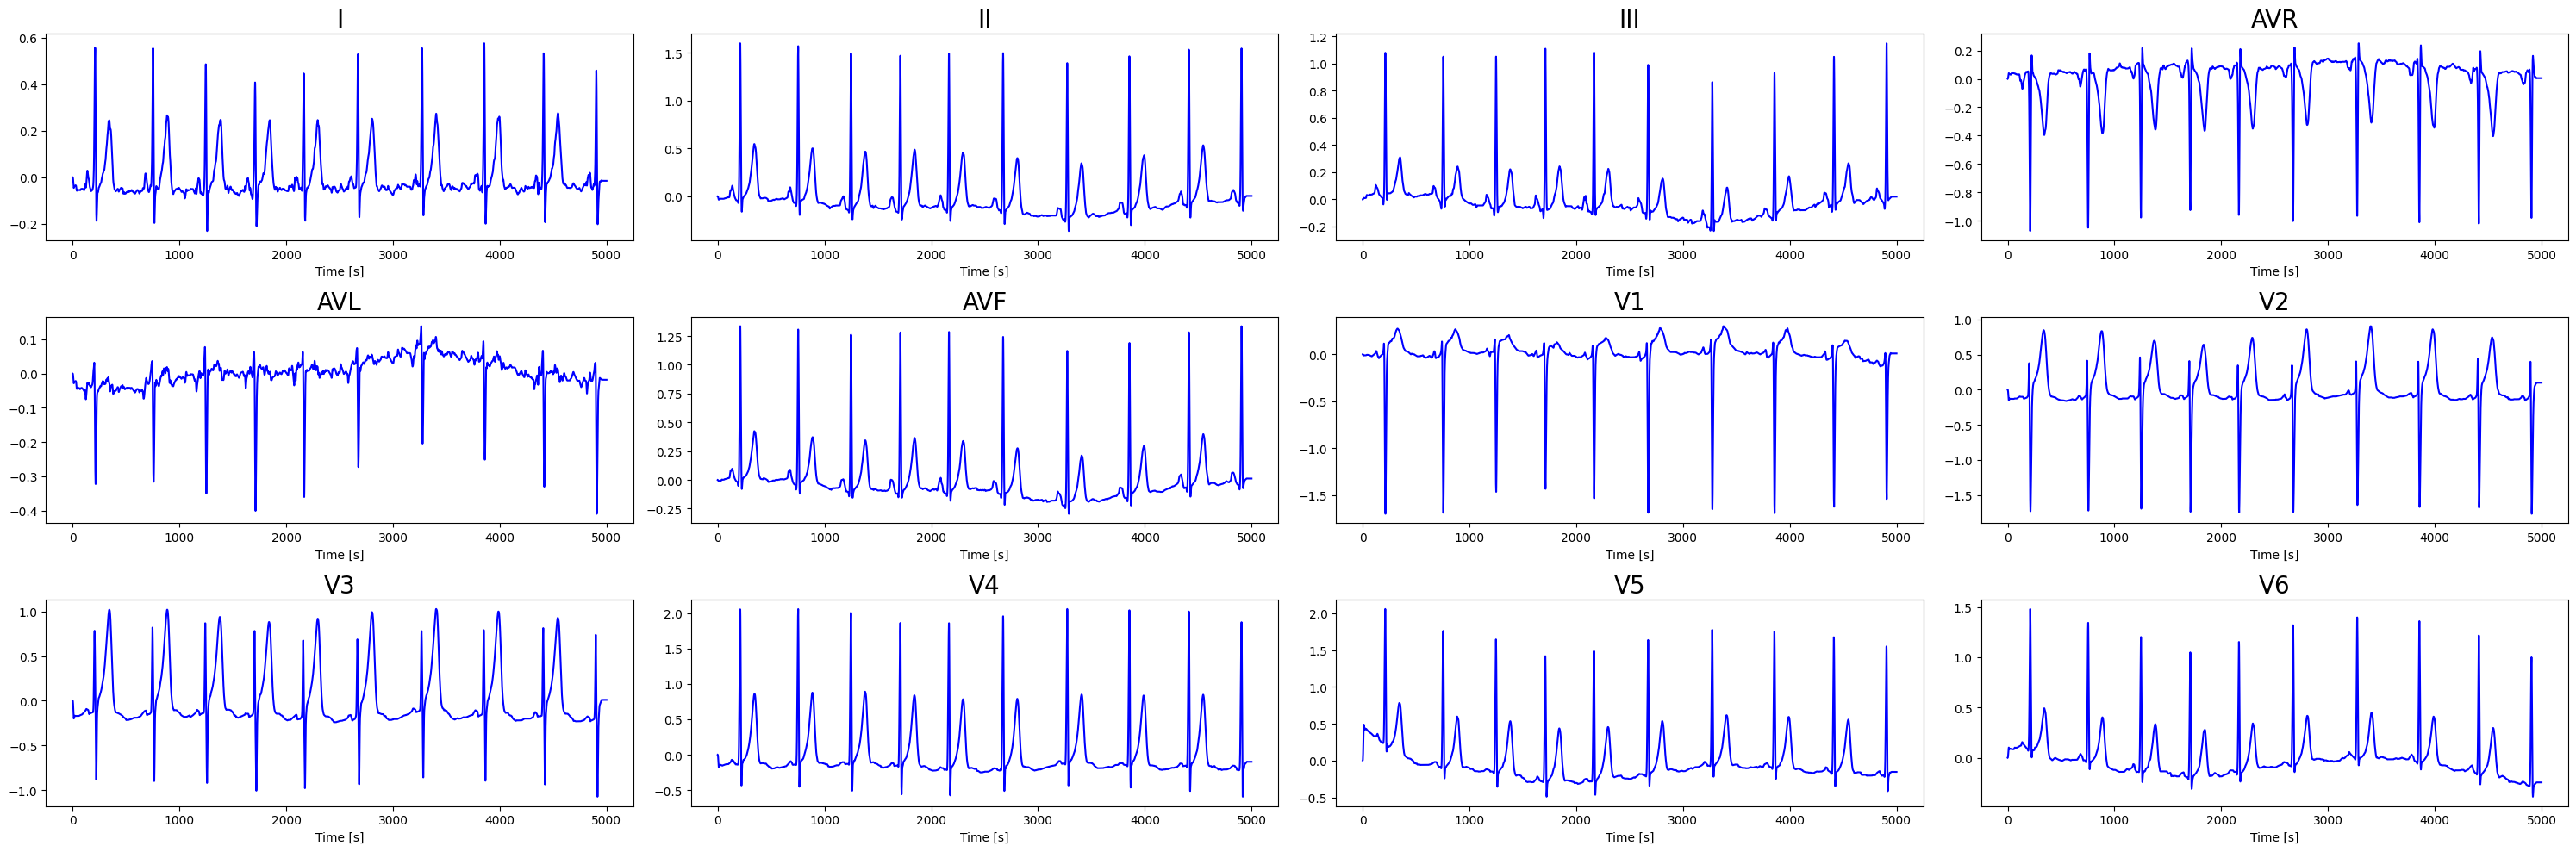

In [12]:
%matplotlib inline
    
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(['NORM', 'MI', 'STTC', 'HYP', 'CD'])
s = 9
fs = 500
print(y_test[s])
for i,lead in enumerate(leadNames):
    x = x_test[s][i][0:5000]
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_xlabel('Time [s]')
    ax1.plot(x,"b-")
    ax1.set_title(leadNames[i], fontsize=20)
fig.tight_layout()

In [13]:
def get_DataLoader(x, y, batch, num_workers, shuffle=False):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=shuffle)
    return dataloader

batch_size = 8
num_workers = 2

train_loader = get_DataLoader(x_train, y_train, batch=batch_size, num_workers=num_workers, shuffle=False)
val_loader = get_DataLoader(x_valid, y_valid, batch=16, num_workers=num_workers, shuffle=False)
test_loader = get_DataLoader(x_test, y_test, batch=16, num_workers=num_workers, shuffle=False)

In [14]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

logits_list = []
gt_list = []
def Evaluate(model, test_loader):
    global gt_list, logits_list
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
                gt_list.append(gt.astype(int))
            
    print(classification_report(gt_list, logits_list, target_names=label_names))

In [15]:
# Fix Seed
seed = 0
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
class AsymmetricLoss(nn.Module):
    # 4,1, 1e-8
    def __init__(self, gamma_neg=3, gamma_pos=2, clip=0.05, eps=1e-5, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()
 
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
 
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
 
        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid
 
        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
 
        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg
 
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w
 
        return -loss.sum()

In [17]:
writer = SummaryWriter("runs/vit")

lr = 1e-5
epochs = 100
model = ViT()
# criterion = nn.MultiLabelSoftMarginLoss()
# criterion = ops.sigmoid_focal_loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=3, verbose=False)
model.to(device)

loss_list=[]
val_loss_list = []

best_loss = np.inf
best_models = []
loss_asl = AsymmetricLoss()

idx = 0
for batch in [1]:
    writer = SummaryWriter("runs/vit/1121")

    train_loader = get_DataLoader(x_train, y_train, batch=batch, num_workers=num_workers, shuffle=False)
    val_loader = get_DataLoader(x_valid, y_valid, batch=16, num_workers=num_workers, shuffle=False)
    test_loader = get_DataLoader(x_test, y_test, batch=16, num_workers=num_workers, shuffle=False)
    for lr in [5e-5]:
        model = ViT()
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        print(f"===============================================================================================")
        print(f"======================= Batch {batch} | Learning Rate {lr} | MIDX {idx} =======================")
        print(f"===============================================================================================")
        
        for ep in range(epochs):
            train_bar = tqdm(train_loader)
            train_total_loss = 0
            for step, (x,y) in enumerate(train_bar):
                x, y = x.to(device), y.to(device)
                
                model.train()
                logits = model(x)
                # loss = criterion(logits, y)
                loss = loss_asl(logits, y)
                # print(loss.shape) # Batch, class
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_total_loss += loss
                train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epochs, loss.item())
                writer.add_scalar(f"Training loss_Batch_{batch}_{lr}", loss, ep * len(train_loader) + step)
        
            
            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                val_bar = tqdm(val_loader)
                for v_step, (val_x, val_y) in enumerate(val_bar):
                    val_x, val_y = val_x.to(device), val_y.to(device)
                    val_logits = model(val_x)
                    loss_v = loss_asl(val_logits, val_y)
                    # loss_v = criterion(val_logits, val_y)
                    val_loss_list.append(loss_v.item())
                    val_loss += loss_v.item()
                    writer.add_scalar(f"Validation loss_Batch_{batch}_{lr}", loss_v, ep * len(val_loader) + step)
                print("Training loss :",(train_total_loss/len(train_loader)).item())
                print("Validation loss :",val_loss/len(val_loader))
        
                if best_loss > val_loss:
                    print("Validation Loss Decrease.. Best Model, Best Loss update")
                    best_loss = val_loss
                    torch.save(model.state_dict(), f"models/1121/Best_Saved_ViT_model_{round((val_loss/len(val_loader))*100,2)}_{ep}_{batch}.pth")
        idx+=1

        torch.save(model.state_dict(), f"models/1121/Best_Saved_ViT_model_FinalEpoch_{batch}_{lr}.pth")
        best_models.append(model)
            
#     early_stopping(loss.mean(), model)
#     if early_stopping.early_stop:
#         break
#         if (i+1) % 5 == 0:
#             logtis = logtis > 0.5
#             acc = (logits == y).float().mean()
#             print(f"EPOCH : {ep} : Loss : {loss.mean().item():.5f}, Acc : {acc.item():.5f}")
    
print("Evaluate")
Evaluate(model,test_loader)

======================= Batch 4 | Learning Rate 1e-05 | MIDX 0 =======================


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 61.50it/s]


Training loss : 1.891408085823059
Validation loss : 6.5752036364655515
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 60.87it/s]


Training loss : 1.6452722549438477
Validation loss : 5.894446660394538
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 60.24it/s]


Training loss : 1.5292143821716309
Validation loss : 5.700585839410895
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 60.03it/s]


Training loss : 1.4542901515960693
Validation loss : 5.537131012302556
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.73it/s]


Training loss : 1.3903688192367554
Validation loss : 5.332465862030308
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.41it/s]


Training loss : 1.3251471519470215
Validation loss : 5.129729644892967
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.48it/s]


Training loss : 1.2710660696029663
Validation loss : 4.878020777549918
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.84it/s]


Training loss : 1.2330315113067627
Validation loss : 4.793466569081834
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.23it/s]


Training loss : 1.1904830932617188
Validation loss : 4.5710388329475435
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.96it/s]


Training loss : 1.1681208610534668
Validation loss : 4.5339968879473265
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.16it/s]


Training loss : 1.1340222358703613
Validation loss : 4.497403802392689
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.10it/s]


Training loss : 1.1187329292297363
Validation loss : 4.464311268775975
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.78it/s]


Training loss : 1.103641152381897
Validation loss : 4.381516717884638
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.83it/s]


Training loss : 1.0845810174942017
Validation loss : 4.373477433914463
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.68it/s]


Training loss : 1.0727829933166504
Validation loss : 4.379596394490978


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.69it/s]


Training loss : 1.0583434104919434
Validation loss : 4.330953105943933
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.62it/s]


Training loss : 1.0398943424224854
Validation loss : 4.347308680347112


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.68it/s]


Training loss : 1.031307578086853
Validation loss : 4.290732718493841
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.57it/s]


Training loss : 1.0137102603912354
Validation loss : 4.321416336107472


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.52it/s]


Training loss : 1.003533959388733
Validation loss : 4.323596758385227


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.35it/s]


Training loss : 0.9892482757568359
Validation loss : 4.303819164293542


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.42it/s]


Training loss : 0.9773969054222107
Validation loss : 4.339279835082625


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.62it/s]


Training loss : 0.9603484869003296
Validation loss : 4.313952123193436


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.64it/s]


Training loss : 0.9536758661270142
Validation loss : 4.284556751926195
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.40it/s]


Training loss : 0.9373601078987122
Validation loss : 4.265192330155743
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.13it/s]


Training loss : 0.9239360094070435
Validation loss : 4.374323317449387


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.58it/s]


Training loss : 0.9104306101799011
Validation loss : 4.290576226090732


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.35it/s]


Training loss : 0.8912808299064636
Validation loss : 4.3174117574953055


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.48it/s]


Training loss : 0.876876711845398
Validation loss : 4.4547163607323


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 54.16it/s]


Training loss : 0.8778308629989624
Validation loss : 4.354787898390261


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.66it/s]


Training loss : 0.8572049736976624
Validation loss : 4.472200124775438


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.02it/s]


Training loss : 0.8450895547866821
Validation loss : 4.532121820536923


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.47it/s]


Training loss : 0.8369562029838562
Validation loss : 4.5077320359068915


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.56it/s]


Training loss : 0.823806881904602
Validation loss : 4.493325337971727


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.17it/s]


Training loss : 0.8048896789550781
Validation loss : 4.66661268118854


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.41it/s]


Training loss : 0.7978872656822205
Validation loss : 4.637945919276373


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.23it/s]


Training loss : 0.7789157629013062
Validation loss : 4.666454210673293


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.13it/s]


Training loss : 0.7752312421798706
Validation loss : 4.877124305729453


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.07it/s]


Training loss : 0.7597060203552246
Validation loss : 4.920014856612846


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.34it/s]


Training loss : 0.7460062503814697
Validation loss : 5.001726803169947


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.03it/s]


Training loss : 0.7345439195632935
Validation loss : 5.074868312165073


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 54.54it/s]


Training loss : 0.715697169303894
Validation loss : 5.113059927339423


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.89it/s]


Training loss : 0.7113752961158752
Validation loss : 5.1756410070750265


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.51it/s]


Training loss : 0.7048174142837524
Validation loss : 5.246032282642034


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.01it/s]


Training loss : 0.6964380145072937
Validation loss : 5.467894191066969


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.88it/s]


Training loss : 0.6803956031799316
Validation loss : 5.553193747725117


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.60it/s]


Training loss : 0.6674132943153381
Validation loss : 5.417863907335011


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.46it/s]


Training loss : 0.6683390140533447
Validation loss : 5.908130256552674


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.22it/s]


Training loss : 0.6500241756439209
Validation loss : 6.451136268437181


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.72it/s]


Training loss : 0.6392146348953247
Validation loss : 5.9766785412618555
======================= Batch 4 | Learning Rate 5e-05 | MIDX 1 =======================


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.34it/s]


Training loss : 1.7596265077590942
Validation loss : 5.939285729029407


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 54.28it/s]


Training loss : 1.422822117805481
Validation loss : 5.218563028122192


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.24it/s]


Training loss : 1.2808648347854614
Validation loss : 4.846764006026803


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.90it/s]


Training loss : 1.2006548643112183
Validation loss : 4.627958550845107


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.32it/s]


Training loss : 1.1527140140533447
Validation loss : 4.643943608079327


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 54.75it/s]


Training loss : 1.1190699338912964
Validation loss : 4.544275274015453


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.12it/s]


Training loss : 1.0906492471694946
Validation loss : 4.439555107730708


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.62it/s]


Training loss : 1.0706517696380615
Validation loss : 4.475694449524902


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.40it/s]


Training loss : 1.0400716066360474
Validation loss : 4.279950627453251


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.90it/s]


Training loss : 1.024053931236267
Validation loss : 4.212245004362167
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.31it/s]


Training loss : 1.0055267810821533
Validation loss : 4.251666201304083


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.38it/s]


Training loss : 0.9928871989250183
Validation loss : 4.264919958702506


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.13it/s]


Training loss : 0.9743940234184265
Validation loss : 4.274253405392442


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.16it/s]


Training loss : 0.9575909376144409
Validation loss : 4.19955062757344
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.89it/s]


Training loss : 0.9417755603790283
Validation loss : 4.321370707799311


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.48it/s]


Training loss : 0.9343164563179016
Validation loss : 4.285818768418543


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.31it/s]


Training loss : 0.9156764149665833
Validation loss : 4.313913354046268


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.92it/s]


Training loss : 0.9102146625518799
Validation loss : 4.202071588333339


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.09it/s]


Training loss : 0.8944043517112732
Validation loss : 4.511090701029181


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.36it/s]


Training loss : 0.885758638381958
Validation loss : 4.534608306950086


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.21it/s]


Training loss : 0.8745936155319214
Validation loss : 4.512773093567591


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.57it/s]


Training loss : 0.8690258860588074
Validation loss : 4.490179176199926


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.35it/s]


Training loss : 0.8513510227203369
Validation loss : 4.386587191934455


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.25it/s]


Training loss : 0.8506916165351868
Validation loss : 4.654764242368202


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.37it/s]


Training loss : 0.833682119846344
Validation loss : 4.374481134763047


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.28it/s]


Training loss : 0.8344711661338806
Validation loss : 4.478899244848452


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.58it/s]


Training loss : 0.8211380839347839
Validation loss : 4.532870566463906


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.37it/s]


Training loss : 0.8112926483154297
Validation loss : 4.913091376491877


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.35it/s]


Training loss : 0.8050038814544678
Validation loss : 4.783638861625707


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.96it/s]


Training loss : 0.7943907976150513
Validation loss : 4.677725988980297


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 45.34it/s]


Training loss : 0.787240743637085
Validation loss : 4.86418717092575


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.16it/s]


Training loss : 0.7910708785057068
Validation loss : 4.630732182498392


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.07it/s]


Training loss : 0.7798598408699036
Validation loss : 4.503315105830153


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.09it/s]


Training loss : 0.7737233638763428
Validation loss : 5.061694809290916


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.77it/s]


Training loss : 0.7695589065551758
Validation loss : 5.049449226083277


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.04it/s]


Training loss : 0.7606529593467712
Validation loss : 4.54989974738256


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.95it/s]


Training loss : 0.7522644400596619
Validation loss : 4.8548653169309715


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.27it/s]


Training loss : 0.7498961687088013
Validation loss : 5.148391426970425


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.25it/s]


Training loss : 0.7428572773933411
Validation loss : 5.006500257748991


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.59it/s]


Training loss : 0.7477421164512634
Validation loss : 5.055358869300041


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.82it/s]


Training loss : 0.7352220416069031
Validation loss : 5.250730887395606


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.76it/s]


Training loss : 0.7325023412704468
Validation loss : 5.786882129434037


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.84it/s]


Training loss : 0.7272718548774719
Validation loss : 5.258828804373197


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.47it/s]


Training loss : 0.7197015881538391
Validation loss : 5.125407154157282


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.85it/s]


Training loss : 0.7191407084465027
Validation loss : 5.309341542252667


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.81it/s]


Training loss : 0.7156895995140076
Validation loss : 5.579428525820171


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.48it/s]


Training loss : 0.7063024640083313
Validation loss : 5.628889315204534


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.43it/s]


Training loss : 0.7016124725341797
Validation loss : 5.51739485459785


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.93it/s]


Training loss : 0.6986867189407349
Validation loss : 5.748697239514355


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.73it/s]


Training loss : 0.6906706690788269
Validation loss : 5.681237470069433
======================= Batch 4 | Learning Rate 0.0001 | MIDX 2 =======================


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.88it/s]


Training loss : 1.7528237104415894
Validation loss : 5.926953357104297


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.91it/s]


Training loss : 1.4530771970748901
Validation loss : 5.454547875548062


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.17it/s]


Training loss : 1.384642243385315
Validation loss : 5.579476609077628


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.02it/s]


Training loss : 1.3504832983016968
Validation loss : 5.469369298791232


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.13it/s]


Training loss : 1.3163530826568604
Validation loss : 5.154730630247561


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.25it/s]


Training loss : 1.290814995765686
Validation loss : 5.173773753588603


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.28it/s]


Training loss : 1.2663445472717285
Validation loss : 5.057931568524609


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.98it/s]


Training loss : 1.2504760026931763
Validation loss : 5.083267877635346


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.41it/s]


Training loss : 1.237154245376587
Validation loss : 4.971182396422782


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.48it/s]


Training loss : 1.227611780166626
Validation loss : 4.884300473618181


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.14it/s]


Training loss : 1.209815263748169
Validation loss : 4.9155721430364805


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.53it/s]


Training loss : 1.2037005424499512
Validation loss : 4.891772651236896


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.28it/s]


Training loss : 1.202150821685791
Validation loss : 4.805608126670802


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.59it/s]


Training loss : 1.1940656900405884
Validation loss : 4.758493444146631


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.38it/s]


Training loss : 1.193427562713623
Validation loss : 4.819126838962782


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.23it/s]


Training loss : 1.1872549057006836
Validation loss : 4.853731781380362


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.14it/s]


Training loss : 1.1910157203674316
Validation loss : 4.820739075473455


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.09it/s]


Training loss : 1.1916028261184692
Validation loss : 4.841134942285547


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.23it/s]


Training loss : 1.1996721029281616
Validation loss : 4.834410836163177


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.84it/s]


Training loss : 1.20200777053833
Validation loss : 4.86029823022346


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.82it/s]


Training loss : 1.201154112815857
Validation loss : 4.785807201307114


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.58it/s]


Training loss : 1.2002938985824585
Validation loss : 4.81278545671402


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.66it/s]


Training loss : 1.2142282724380493
Validation loss : 4.881553955274086


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.51it/s]


Training loss : 1.2159394025802612
Validation loss : 4.89639392073296


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.34it/s]


Training loss : 1.2064017057418823
Validation loss : 4.812885768881672


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.30it/s]


Training loss : 1.2028545141220093
Validation loss : 4.835435423132491


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.22it/s]


Training loss : 1.21397864818573
Validation loss : 4.935106319923923


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.07it/s]


Training loss : 1.2095507383346558
Validation loss : 4.849952009714902


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.18it/s]


Training loss : 1.1977384090423584
Validation loss : 4.8931052717444015


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.00it/s]


Training loss : 1.198203682899475
Validation loss : 4.948180098511857


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.93it/s]


Training loss : 1.2058414220809937
Validation loss : 4.899323293607529


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.82it/s]


Training loss : 1.218846082687378
Validation loss : 4.934862209781664


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.92it/s]


Training loss : 1.2115017175674438
Validation loss : 4.892510186047314


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.89it/s]


Training loss : 1.2063947916030884
Validation loss : 4.896556527647253


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.92it/s]


Training loss : 1.1990097761154175
Validation loss : 4.831336545617613


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.51it/s]


Training loss : 1.209476113319397
Validation loss : 4.910450297947888


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.66it/s]


Training loss : 1.2091014385223389
Validation loss : 4.848993204500033


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.81it/s]


Training loss : 1.201743721961975
Validation loss : 4.885690146929597


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.84it/s]


Training loss : 1.2018309831619263
Validation loss : 4.837851101405


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.83it/s]


Training loss : 1.199393630027771
Validation loss : 4.876176760076932


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.67it/s]


Training loss : 1.1976559162139893
Validation loss : 4.900038912960383


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.88it/s]


Training loss : 1.2093197107315063
Validation loss : 4.884276213711256


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.62it/s]


Training loss : 1.2317965030670166
Validation loss : 4.898712201749897


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.90it/s]


Training loss : 1.2319194078445435
Validation loss : 4.8592715633514265


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.72it/s]


Training loss : 1.2405325174331665
Validation loss : 4.867827504737192


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.90it/s]


Training loss : 1.2382577657699585
Validation loss : 4.856259000900129


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.58it/s]


Training loss : 1.2442244291305542
Validation loss : 4.932827655583212


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.63it/s]


Training loss : 1.2420878410339355
Validation loss : 5.094313258449781


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.00it/s]


Training loss : 1.255599856376648
Validation loss : 5.165541461613625


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.97it/s]


Training loss : 1.2806875705718994
Validation loss : 5.1274886686507966
======================= Batch 4 | Learning Rate 0.0005 | MIDX 3 =======================


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.74it/s]


Training loss : 1.8358396291732788
Validation loss : 6.630265405733291


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.98it/s]


Training loss : 1.5696930885314941
Validation loss : 6.22552891517883


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.72it/s]


Training loss : 1.5720828771591187
Validation loss : 6.287399231026706


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.10it/s]


Training loss : 1.5801142454147339
Validation loss : 6.191231491358857


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.98it/s]


Training loss : 1.591439962387085
Validation loss : 6.266960669325911


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.05it/s]


Training loss : 1.5741446018218994
Validation loss : 6.275517650935203


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.00it/s]


Training loss : 1.5722285509109497
Validation loss : 6.252694794032127


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.81it/s]


Training loss : 1.5642930269241333
Validation loss : 6.221241284723151


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.34it/s]


Training loss : 1.5650032758712769
Validation loss : 6.317271964190757


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.83it/s]


Training loss : 1.560197353363037
Validation loss : 6.1017433867606945


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.99it/s]


Training loss : 1.5445870161056519
Validation loss : 6.257816887881658


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.02it/s]


Training loss : 1.5504305362701416
Validation loss : 6.043922443912454


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.83it/s]


Training loss : 1.5446935892105103
Validation loss : 6.266058891331224


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.17it/s]


Training loss : 1.5437836647033691
Validation loss : 6.18874001067523


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.20it/s]


Training loss : 1.5441257953643799
Validation loss : 6.124078868186637


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.76it/s]


Training loss : 1.5441627502441406
Validation loss : 6.268230650522938


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.16it/s]


Training loss : 1.5461385250091553
Validation loss : 6.286522532162601


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.17it/s]


Training loss : 1.558253288269043
Validation loss : 6.541310448624772


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.02it/s]


Training loss : 1.5497437715530396
Validation loss : 6.239777383194666


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.08it/s]


Training loss : 1.5486197471618652
Validation loss : 6.3260917794214535


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.93it/s]


Training loss : 1.5527535676956177
Validation loss : 6.105644085635878


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.97it/s]


Training loss : 1.544567346572876
Validation loss : 6.0366590131907705


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.08it/s]


Training loss : 1.553951382637024
Validation loss : 6.204234330077149


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.20it/s]


Training loss : 1.5677146911621094
Validation loss : 6.230393322091125


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.84it/s]


Training loss : 1.5708231925964355
Validation loss : 6.210097384779421


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.44it/s]


Training loss : 1.5631242990493774
Validation loss : 6.28144226988701


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.95it/s]


Training loss : 1.566049337387085
Validation loss : 6.2080913874656645


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.03it/s]


Training loss : 1.5591442584991455
Validation loss : 6.188242738105391


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 55.41it/s]


Training loss : 1.5547209978103638
Validation loss : 6.279437041173787


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.35it/s]


Training loss : 1.5663124322891235
Validation loss : 6.253218946935924


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.80it/s]


Training loss : 1.5686419010162354
Validation loss : 6.220671061511453


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.65it/s]


Training loss : 1.5658631324768066
Validation loss : 6.242180780733013


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.07it/s]


Training loss : 1.5612707138061523
Validation loss : 6.293860607495591


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.47it/s]


Training loss : 1.5689494609832764
Validation loss : 6.32179690496018


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.03it/s]


Training loss : 1.566918134689331
Validation loss : 6.2883196835104185


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.03it/s]


Training loss : 1.564460039138794
Validation loss : 6.348113517238669


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.00it/s]


Training loss : 1.5620145797729492
Validation loss : 6.364440935387459


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.13it/s]


Training loss : 1.5543667078018188
Validation loss : 6.164866929729235


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.16it/s]


Training loss : 1.5497463941574097
Validation loss : 6.146025710998605


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.18it/s]


Training loss : 1.556405782699585
Validation loss : 6.199074685301411


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.40it/s]


Training loss : 1.55112624168396
Validation loss : 6.176541779139271


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.07it/s]


Training loss : 1.546141505241394
Validation loss : 6.173552154950356


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.20it/s]


Training loss : 1.5431993007659912
Validation loss : 6.161238588154588


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.22it/s]


Training loss : 1.5442733764648438
Validation loss : 6.129790886352051


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.06it/s]


Training loss : 1.5412137508392334
Validation loss : 6.099278315017212


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.10it/s]


Training loss : 1.5504685640335083
Validation loss : 6.1825863231807


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 56.51it/s]


Training loss : 1.5502655506134033
Validation loss : 6.232020813036183


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 57.95it/s]


Training loss : 1.5457112789154053
Validation loss : 6.102384778462588


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.26it/s]


Training loss : 1.5456780195236206
Validation loss : 6.095512760284285


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 58.18it/s]


Training loss : 1.541133165359497
Validation loss : 6.113015030072704
======================= Batch 8 | Learning Rate 1e-05 | MIDX 4 =======================


100%|████████████████████████████████████████████████████████████████| 219/219 [00:03<00:00, 59.35it/s]


Training loss : 3.763284206390381
Validation loss : 6.579748000184151


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.92it/s]


Training loss : 3.442450523376465
Validation loss : 5.979564776703647


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.64it/s]


Training loss : 3.233729839324951
Validation loss : 5.884538135027777


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.80it/s]


Training loss : 3.082674741744995
Validation loss : 5.728651406558137


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.03it/s]


Training loss : 2.9712188243865967
Validation loss : 5.5733158762596515


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.22it/s]


Training loss : 2.8770666122436523
Validation loss : 5.48991075335028


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.27it/s]


Training loss : 2.7745254039764404
Validation loss : 5.330520196592427


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.96it/s]


Training loss : 2.6830990314483643
Validation loss : 5.102849573849543


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.68it/s]


Training loss : 2.581009864807129
Validation loss : 4.919493383468558


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.44it/s]


Training loss : 2.492418050765991
Validation loss : 4.792437001450421


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.38it/s]


Training loss : 2.4249587059020996
Validation loss : 4.7104990966788165


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 44.57it/s]


Training loss : 2.376657009124756
Validation loss : 4.609161375864455


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.26it/s]


Training loss : 2.325796365737915
Validation loss : 4.5819000947421


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.31it/s]


Training loss : 2.295560836791992
Validation loss : 4.55176633623637


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.96it/s]


Training loss : 2.261018991470337
Validation loss : 4.484276093848764


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.12it/s]


Training loss : 2.237039089202881
Validation loss : 4.480990981946797


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.03it/s]


Training loss : 2.208997964859009
Validation loss : 4.46775743188379


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.81it/s]


Training loss : 2.185049533843994
Validation loss : 4.464247326872664


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 51.68it/s]


Training loss : 2.157520294189453
Validation loss : 4.463875214803164


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.07it/s]


Training loss : 2.138709783554077
Validation loss : 4.364201669279299


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.01it/s]


Training loss : 2.1132025718688965
Validation loss : 4.372645711245602


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.25it/s]


Training loss : 2.0912981033325195
Validation loss : 4.365612841632268


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.98it/s]


Training loss : 2.0631027221679688
Validation loss : 4.469320696782848


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.79it/s]


Training loss : 2.041435956954956
Validation loss : 4.332312112529528


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.48it/s]


Training loss : 2.0345535278320312
Validation loss : 4.314257238009205


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.19it/s]


Training loss : 2.003959894180298
Validation loss : 4.347757790186634


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.69it/s]


Training loss : 1.9822945594787598
Validation loss : 4.299562643107758


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.15it/s]


Training loss : 1.9804983139038086
Validation loss : 4.265774742653381


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.81it/s]


Training loss : 1.9419054985046387
Validation loss : 4.276225637627519


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.26it/s]


Training loss : 1.9262741804122925
Validation loss : 4.39124888426637


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.88it/s]


Training loss : 1.904319167137146
Validation loss : 4.318846347125153


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.05it/s]


Training loss : 1.8910646438598633
Validation loss : 4.287454295920455


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 52.73it/s]


Training loss : 1.8633263111114502
Validation loss : 4.313576973736558


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.85it/s]


Training loss : 1.8396788835525513
Validation loss : 4.336627809424378


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.77it/s]


Training loss : 1.8360775709152222
Validation loss : 4.253933587575068


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 53.02it/s]


Training loss : 1.8138104677200317
Validation loss : 4.3426389329509645


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.79it/s]


Training loss : 1.7963826656341553
Validation loss : 4.306018592560128


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.30it/s]


Training loss : 1.7664936780929565
Validation loss : 4.328079659100537


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.83it/s]


Training loss : 1.751455307006836
Validation loss : 4.310403568559586


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.47it/s]


Training loss : 1.7440170049667358
Validation loss : 4.362882351766438


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.45it/s]


Training loss : 1.7136704921722412
Validation loss : 4.399358221929368


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.10it/s]


Training loss : 1.7069131135940552
Validation loss : 4.46608278087285


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.12it/s]


Training loss : 1.6964060068130493
Validation loss : 4.5010275176671


100%|████████████████████████████████████████████████████████████████| 219/219 [00:05<00:00, 43.22it/s]


Training loss : 1.671231746673584
Validation loss : 4.489832279889007


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.65it/s]


Training loss : 1.6456574201583862
Validation loss : 4.531052367327964


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.57it/s]


Training loss : 1.6448763608932495
Validation loss : 4.622626703079432


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.73it/s]


Training loss : 1.6117147207260132
Validation loss : 4.503655276886405


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.30it/s]


Training loss : 1.6019902229309082
Validation loss : 4.7775867551429085


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.48it/s]


Training loss : 1.5858045816421509
Validation loss : 4.647426842554519


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.54it/s]


Training loss : 1.5607588291168213
Validation loss : 4.75735390567344
======================= Batch 8 | Learning Rate 5e-05 | MIDX 5 =======================


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.41it/s]


Training loss : 3.6226985454559326
Validation loss : 6.04102922901171


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.72it/s]


Training loss : 3.0025734901428223
Validation loss : 5.397710758801464


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.58it/s]


Training loss : 2.688961982727051
Validation loss : 4.9524856898338285


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 45.26it/s]


Training loss : 2.480496883392334
Validation loss : 4.842775644777028


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.96it/s]


Training loss : 2.3579297065734863
Validation loss : 4.560610078785517


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.09it/s]


Training loss : 2.2756381034851074
Validation loss : 4.473787666455796


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.96it/s]


Training loss : 2.201651096343994
Validation loss : 4.2980957553811265


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 44.91it/s]


Training loss : 2.1545140743255615
Validation loss : 4.302462061790571


100%|████████████████████████████████████████████████████████████████| 219/219 [00:05<00:00, 43.36it/s]


Training loss : 2.083381414413452
Validation loss : 4.28045641668311


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.17it/s]


Training loss : 2.023449659347534
Validation loss : 4.233966396279531


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 50.06it/s]


Training loss : 1.9836816787719727
Validation loss : 4.169139051001911
Validation Loss Decrease.. Best Model, Best Loss update


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 47.79it/s]


Training loss : 1.9440733194351196
Validation loss : 4.210117613343888


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.05it/s]


Training loss : 1.9111987352371216
Validation loss : 4.183729619196017


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.16it/s]


Training loss : 1.8701915740966797
Validation loss : 4.173745494999298


100%|████████████████████████████████████████████████████████████████| 219/219 [00:05<00:00, 43.56it/s]


Training loss : 1.8218132257461548
Validation loss : 4.218461605511844


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.42it/s]


Training loss : 1.793021559715271
Validation loss : 4.187052080076035


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 46.73it/s]


Training loss : 1.7614604234695435
Validation loss : 4.394020268361863


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.39it/s]


Training loss : 1.7213667631149292
Validation loss : 4.396201218099899


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.13it/s]


Training loss : 1.6806564331054688
Validation loss : 4.334081608410839


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 49.52it/s]


Training loss : 1.6511327028274536
Validation loss : 4.5459183258553075


100%|████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 48.86it/s]


Training loss : 1.6319643259048462
Validation loss : 4.430980232208287


Train Epoch[22/50] loss: 1.972:  48%|██████████████▊                | 835/1747 [00:25<00:27, 33.34it/s]


KeyboardInterrupt: 

In [27]:
model_best = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
# model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
model_best.load_state_dict(torch.load("models/1121/Best_Saved_ViT_model_FinalEpoch_8_1e-05.pth"))

<All keys matched successfully>

In [28]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
def extract_metrix(idx ,lr, batch ,model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    print(f"==================== lr : {lr} | Batch : {batch} | Model IDX : {idx} ====================")
    print(f"Exact Match Ratio, MR : : {accuracy_score(gt_list, logits_list)}")
    print(f"Hamming Loss : {hamming_loss(gt_list, logits_list)}")
    print(classification_report(gt_list, logits_list, target_names=label_names))
    MR = np.all(np.array(logits_list) == np.array(gt_list), axis=1).mean()

In [29]:
extract_metrix(0, 1e-5, 1, model_best, test_loader)

100%|████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.38it/s]

==================== lr : 1e-05 | Batch : 1 | Model IDX : 0 ====================
Exact Match Ratio, MR : : 0.5098443223443223
Hamming Loss : 0.14665750915750916
              precision    recall  f1-score   support

        NORM       0.81      0.78      0.79      1717
          MI       0.78      0.50      0.61      1222
        STTC       0.73      0.55      0.63      1083
         HYP       0.83      0.52      0.64      1016
          CD       0.63      0.55      0.59       558

   micro avg       0.77      0.61      0.68      5596
   macro avg       0.76      0.58      0.65      5596
weighted avg       0.77      0.61      0.67      5596
 samples avg       0.64      0.61      0.61      5596




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
extract_metrix(0, 1e-5, 1, model, test_loader)